Delay Line Simulation Code

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate the endpoints of a mirror given center, length, and angle
def calculate_mirror_endpoints(center, length, angle):
    half_length = length / 2
    angle_rad = np.radians(angle)
    start = (
        center[0] - half_length * np.cos(angle_rad),
        center[1] - half_length * np.sin(angle_rad),
    )
    end = (
        center[0] + half_length * np.cos(angle_rad),
        center[1] + half_length * np.sin(angle_rad),
    )
    return start, end

# Function to find the intersection of two lines
def find_intersection(p1, p2, p3, p4, eps=1e-9):
    # Laser direction (t parameter)
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    r = np.array([x2 - x1, y2 - y1], dtype=float)  # laser direction
    s = np.array([x4 - x3, y4 - y3], dtype=float)  # mirror direction

    rxs = r[0]*s[1] - r[1]*s[0]
    if abs(rxs) < eps:
        return None  # parallel / nearly parallel

    qp = np.array([x3 - x1, y3 - y1], dtype=float)

    # Solve p1 + t r = p3 + u s
    t = (qp[0]*s[1] - qp[1]*s[0]) / rxs
    u = (qp[0]*r[1] - qp[1]*r[0]) / rxs

    # Mirror segment constraint: u in [0, 1]
    # Laser ray constraint: t >= 0 (in front of start)
    if t >= -eps and -eps <= u <= 1 + eps:
        return (x1 + t*r[0], y1 + t*r[1])

    return None

# Function to calculate the reflection of a laser beam
def reflect_laser(laser_start, laser_angle, mirrors, last_mirror):
    laser_angle_rad = np.radians(laser_angle)
    laser_far_end = (
        laser_start[0] + np.cos(laser_angle_rad) * 1000,
        laser_start[1] + np.sin(laser_angle_rad) * 1000,
    )
    
    closest_intersection = None
    closest_mirror = None
    min_distance = float('inf')

    # Find the closest intersection, ignoring the last mirror hit
    for mirror in mirrors:
        if mirror == last_mirror:
            continue
        intersection = find_intersection(laser_start, laser_far_end, mirror[0], mirror[1])
        if intersection is not None:
            distance = np.linalg.norm(np.array(intersection) - np.array(laser_start))
            if distance < min_distance:
                min_distance = distance
                closest_intersection = intersection
                closest_mirror = mirror

    if closest_intersection is None:
        return None, None, None  # No reflection
    
    # Reflection calculation
    mirror_start, mirror_end = closest_mirror
    mirror_vector = np.array([mirror_end[0] - mirror_start[0], mirror_end[1] - mirror_start[1]])
    mirror_length = np.linalg.norm(mirror_vector)
    mirror_unit_vector = mirror_vector / mirror_length
    normal_vector = np.array([-mirror_unit_vector[1], mirror_unit_vector[0]])
    incident_vector = np.array([closest_intersection[0] - laser_start[0], closest_intersection[1] - laser_start[1]])
    reflection_vector = (
        incident_vector - 2 * np.dot(incident_vector, normal_vector) * normal_vector
    )
    reflected_end = (
        closest_intersection[0] + reflection_vector[0],
        closest_intersection[1] + reflection_vector[1],
    )
    return closest_intersection, reflected_end, closest_mirror

In [5]:
# Function to calculate distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Simulate laser reflections with length calculation
def simulate_laser_with_length(laser_start, laser_angle, mirrors, max_reflections=36):
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    laser_path = [laser_start]  # Track laser path

    for _ in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(current_position, current_angle, mirrors, last_mirror)
        if intersection is None:
            # No more intersections; add final endpoint and break
            laser_far_end = (
                current_position[0] + np.cos(np.radians(current_angle)) * 1000,
                current_position[1] + np.sin(np.radians(current_angle)) * 1000,
            )
            laser_path.append(laser_far_end)
            break

        # Update the path and continue simulation
        laser_path.append(intersection)
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror

    # Calculate total laser length
    total_length = sum(calculate_distance(laser_path[i], laser_path[i + 1]) for i in range(len(laser_path) - 2))
    return laser_path, total_length

def extend_line(p1, p2):
    # Calculate the length of the line
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    # Extend the line in both directions
    new_p1 = (p1[0] - 0.73*dx, p1[1] - 0.73*dy)  # Extend p1 backwards
    new_p2 = (p2[0] + 0.73*dx, p2[1] + 0.73*dy)  # Extend p2 forwards
    return new_p1, new_p2

def create_orthogonal_line_at_endpoint(endpoint, other_endpoint, length=44):
    """Create an orthogonal line of the specified length at a given endpoint."""
    # Calculate the direction vector of the original line
    dx = other_endpoint[0] - endpoint[0]
    dy = other_endpoint[1] - endpoint[1]
    
    # Get orthogonal direction
    orthogonal_dx = -dy
    orthogonal_dy = dx
    magnitude = np.sqrt(orthogonal_dx**2 + orthogonal_dy**2)
    unit_dx = orthogonal_dx / magnitude
    unit_dy = orthogonal_dy / magnitude

    # Compute the two endpoints of the orthogonal line
    ortho_p1 = (endpoint[0] + unit_dx * length, endpoint[1] + unit_dy * length)
    ortho_p2 = (endpoint[0] - unit_dx * length, endpoint[1] - unit_dy * length)
    return ortho_p1, ortho_p2

def select_furthest_orthogonal_line(endpoint, ortho_p1, ortho_p2, reference_x=100):
    """Select the orthogonal line endpoint furthest away from reference_x."""
    # Calculate distances from reference_x for each orthogonal endpoint
    dist_ortho_p1 = abs(ortho_p1[0] - reference_x)
    dist_ortho_p2 = abs(ortho_p2[0] - reference_x)
    
    # Return the endpoint further from reference_x
    if dist_ortho_p1 > dist_ortho_p2:
        return (endpoint, ortho_p1)
    else:
        return (endpoint, ortho_p2)

def process_mirrors(mirrors):
    doubled_lines = []
    orthogonal_lines = []
    
    for p1, p2 in mirrors:
        # Double the length of the original line
        extended_p1, extended_p2 = extend_line(p1, p2)
        doubled_lines.append((extended_p1, extended_p2))

        # Create orthogonal lines at the endpoints of the doubled line
        ortho_p1_a, ortho_p1_b = create_orthogonal_line_at_endpoint(extended_p1, extended_p2)
        ortho_p2_a, ortho_p2_b = create_orthogonal_line_at_endpoint(extended_p2, extended_p1)
        
        # Select only the orthogonal line furthest from x=100
        orthogonal_lines.append(select_furthest_orthogonal_line(extended_p1, ortho_p1_a, ortho_p1_b))
        orthogonal_lines.append(select_furthest_orthogonal_line(extended_p2, ortho_p2_a, ortho_p2_b))

    return doubled_lines, orthogonal_lines

In [7]:
# The diameter of usable mirror. Given 1 inch mirror: 25.4mm. Clear aperture from spec sheet: 22.9mm.
# 3mm diameter beam. 22.9 - (3/2) = 21.4 mm
mirror_lengths = [21.4, 21.4, 21.4, 21.4]

# Set up the laser
laser_start = (0, 100)
laser_angle = 0  # Initial laser angle in degrees

In [9]:
#Quad Cell Locations
qc_1 = np.array([-100, 137])
qc_2 = np.array([-300, 190])

In [11]:
def execution(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    mirrors = []

    # MIRROR CONFIGURATION
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a] #in degrees

    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    # Initialize plot
    plt.figure(figsize=(12, 10))
    plt.scatter(*laser_start, color='red', label="Laser Source", linewidth=1)

    #Piezo mount outline visualizer
    doubled_lines, orthogonal_lines = process_mirrors(mirrors)

    # Draw the mirrors
    for i, mirror in enumerate(mirrors):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], color = 'black', linewidth=3)

    #Draw piezo mirror mounts outline for fitting purposes
    for i, mirror in enumerate(doubled_lines):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], linewidth=1, color = 'black')

    for i, mirror in enumerate(orthogonal_lines):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], linewidth=1, color = 'black')

    # Simulate laser reflections
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    reflection_count = 0

    for i in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(current_position, current_angle, mirrors, last_mirror)
        if intersection is None:
            # No more intersections
            plt.plot(
                [current_position[0], current_position[0] + np.cos(np.radians(current_angle)) * 1000],
                [current_position[1], current_position[1] + np.sin(np.radians(current_angle)) * 1000],
                'g--'
            )
            break

        # Draw the laser and reflection
        plt.plot([current_position[0], intersection[0]], [current_position[1], intersection[1]], 'r-', linewidth =1)
        #plt.plot([intersection[0], reflected_end[0]], [intersection[1], reflected_end[1]], 'g-')
        #plt.scatter(*intersection, color='orange', label=f"Intersection {i+1}")
    
        # Update for next reflection
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror
        reflection_count += 1

    laser_path, total_length = simulate_laser_with_length(laser_start, laser_angle, mirrors)

    #Indicate where to cut off laser distance calculation (x=?)
    a=laser_path[-2]
    b=laser_path[-1]
    x=0
    slope = (b[1] - a[1]) / (b[0] - a[0])
    y = a[1] + slope * (x - a[0])
    x_point = (x, y)
    distance = np.sqrt((x_point[0] - a[0])**2 + (x_point[1] - a[1])**2)

    #Identify if the exiting beam gets clipped with M4
    a = np.array([a[0], a[1]])
    b = np.array([b[0], b[1]])
    m = np.array([m4cx, m4cy])
    v = b - a
    d = np.array([np.cos(np.deg2rad(m4a)), np.sin(np.deg2rad(m4a))])
    A = np.column_stack((v, -d))
    t, s = np.linalg.solve(A, m - a)
    p = a + t * v if 0 <= t <= 1 else None
    dist = np.linalg.norm(p - m)
    if dist >= 14.3: # Mirror diameter = 25.4mm. laser beam diameter = 3mm. (25.4/2) + (3/2) + 0.1(<- additional edge of mirror error)
        print("NOT CLIPPED, room to spare: ", dist-14.3, "mm")
    else:
        print("CLIPPED, ", dist-14.3, 'mm too much')
        
    print("Laser Path:", laser_path)
    print("Total Laser Length:", total_length+distance, "mm")
    print("Total Number of Reflection (N_R) = ", reflection_count)

    # Finalize plot
    plt.xlim(-310, 250)
    plt.ylim(-10, 210)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Laser Reflection with Multiple Mirrors")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.grid(True, linewidth=0.3)
    plt.plot([qc_1[0],qc_1[0]],[qc_1[1] - 2, qc_1[1] + 2], linewidth=4, label='QC1') # Quadcell Detector 1
    plt.plot([qc_2[0],qc_2[0]],[qc_2[1] - 2, qc_2[1] + 2], linewidth=4, label='QC2') # Quadcell Detector 2
    plt.legend(prop={'size': 8})
    plt.show()

NOT CLIPPED, room to spare:  2.0271582182506798 mm
Laser Path: [(0, 100), (161.0674501826122, 100.0), (21.04006370830521, 66.310015857612), (179.38197375018373, 66.64717406340581), (38.55990398115128, 107.78374493922558), (160.5174721410175, 104.63703361054257), (20.931230284415847, 67.21934546906579), (178.93218902716046, 63.479291455116304), (-787.864444058928, 319.0262934985821)]
Total Laser Length: 1219.7754881851383 mm
Total Number of Reflection (N_R) =  7


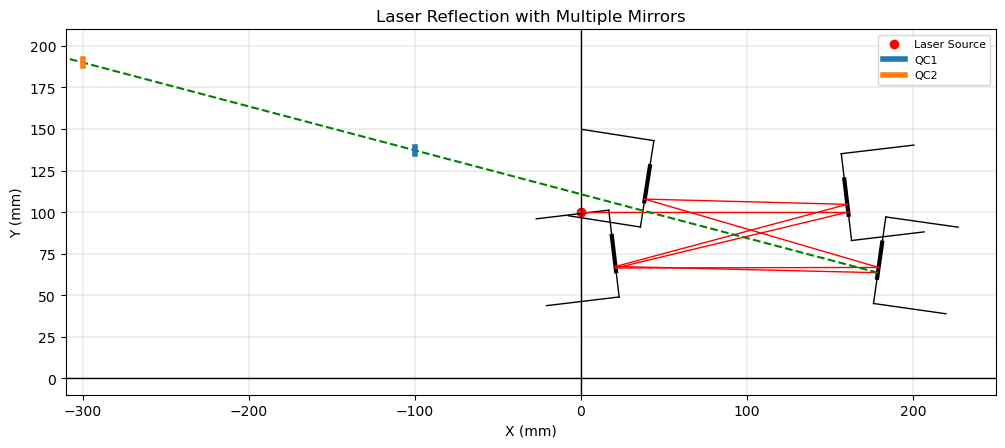

In [13]:
execution(160, 109, #M1, (x,y)
          20, 75, #M2, (x,y)
          180, 71, #M3, (x,y)
          40, 117, #M4, (x,y)
          96.764, 96.825, 81.919, 81.119) # Angle from positive x-axis (M1, M2, M3, M4)

In [15]:
def execution_identifier(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    mirrors = []

    # MIRROR CONFIGURATION
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a] #in degrees

    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    #Piezo mount outline visualizer
    doubled_lines, orthogonal_lines = process_mirrors(mirrors)

    # Simulate laser reflections
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None

    laser_path, total_length = simulate_laser_with_length(laser_start, laser_angle, mirrors)

    #Indicate where to cut off laser distance calculation (x=?)
    a=laser_path[-2]
    b=laser_path[-1]
    x=0
    slope = (b[1] - a[1]) / (b[0] - a[0])
    y = a[1] + slope * (x - a[0])
    x_point = (x, y)
    distance = np.sqrt((x_point[0] - a[0])**2 + (x_point[1] - a[1])**2)

    last_two = laser_path[-2:]
    exit_slope = (last_two[1][1]-last_two[0][1])/(last_two[1][0]-last_two[0][0])
    y_int=last_two[1][1]-exit_slope*last_two[1][0]
    y100=exit_slope*-100+y_int
    y200=exit_slope*-200+y_int
    y300=exit_slope*-300+y_int
    y525=exit_slope*-525+y_int
    print(f"Exit slope: {exit_slope}")
    print(f"Total length: {total_length + distance}")
    print(f"y100: {y100-137}")
    print(f"y200: {y200-163.5}")
    print(f"y300: {y300-190}")
    print(f"y525: {y525-249.63}")

    return exit_slope, total_length + distance, y100-137, y300-190

In [19]:
# Returns (1) the exiting beam slope, (2) Optical Path Length (L), (3) X-intercept at x=-100, (4) X-intercept at x=-300

execution_identifier(160, 109, #M1, (x,y)
                     20, 75, #M2, (x,y)
                     180, 71, #M3, (x,y)
                     40, 117, #M4, (x,y)
                     96.764, 96.825, 81.919, 81.119) # Angle from positive x-axis (M1, M2, M3, M4)

Exit slope: -0.26432342986936175
Total length: 1219.7754881851383
y100: 0.20760435974452207
y200: 0.13994734668071374
y300: 0.07229033361687698
y525: -0.08493794577671565


(-0.26432342986936175,
 1219.7754881851383,
 0.20760435974452207,
 0.07229033361687698)